# Cài đặt

In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.2 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

In [3]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=84c4f3fe077288941faa51be9e88bbe4c5f02a1a577d5603101fa88182694f2c
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


# Thư viện

In [46]:
import pandas as pd
import numpy as np
from transformers import pipeline
import re
import string
import nltk
from underthesea import sent_tokenize, word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from joblib import load
from joblib import dump
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Input

In [5]:
# Tải dữ liệu từ file Excel
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
folder = '/content/gdrive/My Drive/KHÓA LUẬN TỐT NGHIỆP/GGmaps/'

Mounted at /content/gdrive


In [6]:
df = pd.read_excel(folder + 'Dataset.xlsx')
df.head()

,source_name,rating,review
0,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"Trung tâm hỗ trợ sinh viên cực kì tốt, các anh..."
1,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,Mấy chị dễ thương hỗ trợ nhiệt tình
2,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,5,"Trung tâm rất okela luôn nè , mấy chị và giảng..."
3,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"em rất vui vì được tư vấn rất nhiệt tình, và g..."
4,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"Trung tâm có bài test rõ rãng, giáo viên hướng..."


# Tổng quan dữ liệu

In [7]:
# Tổng số dòng, số cột của bộ dữ liệu
print ('Các cột hiện có của bộ dữ liệu:')
for x in df.columns:
  print('>', x)
print(f"Bộ dữ liệu bao gồm {df.shape[1]} cột và {df.shape[0]} dòng")

Các cột hiện có của bộ dữ liệu:
> source_name
> rating
> review
Bộ dữ liệu bao gồm 3 cột và 2082 dòng


# Tiền xử lý

## Kiểm tra dữ liệu thiếu

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_name  2082 non-null   object
 1   rating       2082 non-null   int64 
 2   review       2082 non-null   object
dtypes: int64(1), object(2)
memory usage: 48.9+ KB


In [ ]:
df.isna().sum()

,0
source_name,0
rating,0
review,0


## Chuẩn hóa

In [9]:
# Tạo danh sách stopwords
stopwords = set([
    "là", "có", "và", "của", "trong", "với", "cho", "tại",
    "để", "cái", "này", "những", "đã", "thì", "về",
    "khi", "mà", "cùng", "tôi", "bạn", "đó", "nếu", "từng",
    "cũng", "chúng", "đi", "tất", "một", "như", "do",
    "được", "có thể", "thế", "lại", "thêm", "nhưng", "đây", "nhiều",
    "vì", "như", "nên", "khiến", "sẽ", "bị", "bởi", "cả", "vậy", "rất", "rồi",
    "vào", "khác", "chỉ", "còn", "mình", "mày", "hay", "ở", "luôn", "các"
])

def preprocess_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt
    text = re.sub(r'[^\w\s]', '', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    # Tách từ
    words = word_tokenize(text)
    # Loại bỏ từ dừng
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# Áp dụng hàm chuẩn hóa vào cột 'review'
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [10]:
df

,source_name,rating,review,cleaned_review
0,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"Trung tâm hỗ trợ sinh viên cực kì tốt, các anh...",trung tâm hỗ trợ sinh viên cực kì tốt anh chị ...
1,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,Mấy chị dễ thương hỗ trợ nhiệt tình,mấy chị dễ thương hỗ trợ nhiệt tình
2,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,5,"Trung tâm rất okela luôn nè , mấy chị và giảng...",trung tâm okela nè mấy chị giảng viên vui vẽ d...
3,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"em rất vui vì được tư vấn rất nhiệt tình, và g...",em vui tư vấn nhiệt tình giải đáp thắc mắc rõ ...
4,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"Trung tâm có bài test rõ rãng, giáo viên hướng...",trung tâm bài test rõ rãng giáo viên hướng dẫn...
...,...,...,...,...
2077,English Language Center Athena,4,"'Nhìn chung, tôi hài lòng'",nhìn chung hài lòng
2078,Amslink English Center - Liễu Giai,5,"'Chất lượng giảng dạy là rất tốt, chú ý đến si...",chất lượng giảng dạy tốt chú ý đến sinh viên
2079,Amslink English Center - Liễu Giai,5,"'Giáo viên tốt, cơ sở và thiết bị tốt, đủ để p...",giáo viên tốt cơ sở thiết bị tốt đủ phục vụ nh...
2080,Amslink English Center - Liễu Giai,5,chất lượng ok,chất lượng ok


## Gán nhãn

In [11]:
def label_sentiment(rating):
    if rating > 3:
        return 'positive'
    else:
        return 'negative'

# Gán nhãn cho cột 'sentiment' dựa trên cột 'rating'
df['sentiment'] = df['rating'].apply(label_sentiment)

In [12]:
df

,source_name,rating,review,cleaned_review,sentiment
0,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"Trung tâm hỗ trợ sinh viên cực kì tốt, các anh...",trung tâm hỗ trợ sinh viên cực kì tốt anh chị ...,positive
1,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,Mấy chị dễ thương hỗ trợ nhiệt tình,mấy chị dễ thương hỗ trợ nhiệt tình,positive
2,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,5,"Trung tâm rất okela luôn nè , mấy chị và giảng...",trung tâm okela nè mấy chị giảng viên vui vẽ d...,positive
3,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"em rất vui vì được tư vấn rất nhiệt tình, và g...",em vui tư vấn nhiệt tình giải đáp thắc mắc rõ ...,positive
4,Trung Tâm Tiếng Anh Jaxtina - Cơ sở Phú Nhuận,4,"Trung tâm có bài test rõ rãng, giáo viên hướng...",trung tâm bài test rõ rãng giáo viên hướng dẫn...,positive
...,...,...,...,...,...
2077,English Language Center Athena,4,"'Nhìn chung, tôi hài lòng'",nhìn chung hài lòng,positive
2078,Amslink English Center - Liễu Giai,5,"'Chất lượng giảng dạy là rất tốt, chú ý đến si...",chất lượng giảng dạy tốt chú ý đến sinh viên,positive
2079,Amslink English Center - Liễu Giai,5,"'Giáo viên tốt, cơ sở và thiết bị tốt, đủ để p...",giáo viên tốt cơ sở thiết bị tốt đủ phục vụ nh...,positive
2080,Amslink English Center - Liễu Giai,5,chất lượng ok,chất lượng ok,positive


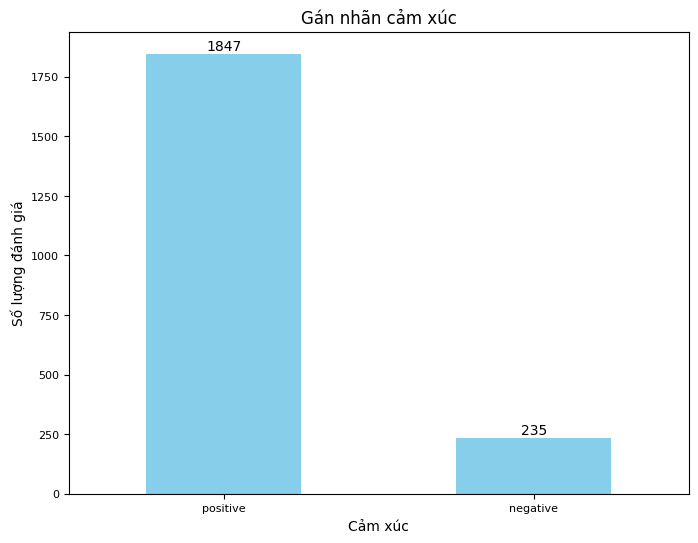

In [13]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
bars = sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Gán nhãn cảm xúc', fontsize=12)
plt.xlabel('Cảm xúc', fontsize=10)
plt.ylabel('Số lượng đánh giá', fontsize=10)
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             int(bar.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()

## Tách từ

In [14]:
def tokenizer(text):
    tokens = []
    for sent in sent_tokenize(text):
        words = word_tokenize(sent)
        tokens.extend(words)
    tokens = [word for word in tokens if word not in string.punctuation]

    return tokens

## Wordcloud

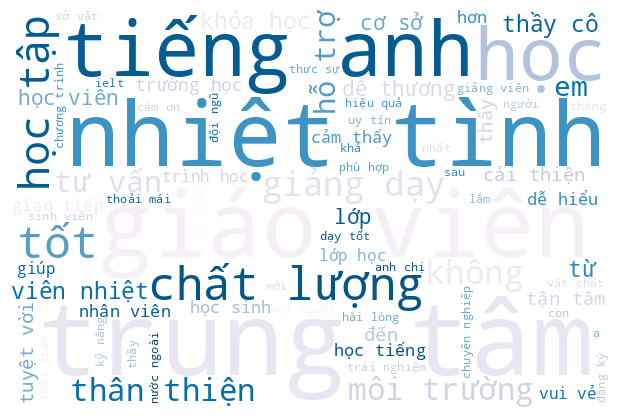

In [15]:
all_tokens = []
for sentence in df['cleaned_review']:
    normalized_sentence = preprocess_text(sentence)
    tokens = tokenizer(normalized_sentence)
    all_tokens.extend(tokens)

text = ' '.join(all_tokens)

# Tạo WordCloud
wordcloud = WordCloud(width=600, height=400,
                      background_color='white',
                      stopwords=None,
                      min_font_size=10, colormap='PuBu').generate(text)

plt.figure(figsize=(6, 4), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# Huấn luyện mô hình

In [16]:
# Chia dữ liệu thành 70% train và 30% temp_data (chứa val và test)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

# Chia temp_data thành 50% validation và 50% test
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['sentiment'])

# Tạo tập train, validation, và test cho mô hình Logistic Regression
train_x = train_data['cleaned_review'].tolist()
train_x=[preprocess_text(sentence)for sentence in train_x]
all_tokens_train = [tokenizer(sentence) for sentence in train_x]

valid_x = val_data['cleaned_review'].tolist()
valid_x=[preprocess_text(sentence)for sentence in valid_x]
all_tokens_valid = [tokenizer(sentence) for sentence in valid_x]

test_x = test_data['cleaned_review'].tolist()
test_x=[preprocess_text(sentence)for sentence in test_x]
all_tokens_test = [tokenizer(sentence) for sentence in test_x]

train_y = train_data['sentiment'].tolist()
valid_y = val_data['sentiment'].tolist()
test_y = test_data['sentiment'].tolist()

## TF-IDF

In [17]:
# Tạo TF-IDF cho tập train, validation và test
vectorizer = TfidfVectorizer()

# Fit và transform cho tập train
train_x_tfidf = vectorizer.fit_transform(train_x)

# Transform cho tập validation và test
valid_x_tfidf = vectorizer.transform(valid_x)
test_x_tfidf = vectorizer.transform(test_x)

## Word2Vec

In [18]:
# Cài đặt các chỉ số
min_count = 2
window = 10
vector_size = 100
alpha = 1e-3
min_alpha = 1e-4
negative = 10

In [19]:
word_sents_train=[sent for sent in all_tokens_train]
# Tạo mô hình Word2Vec
w2v_model = Word2Vec(min_count=min_count, window=window, vector_size=vector_size, alpha=alpha, min_alpha=min_alpha, negative=negative, sg=1)
# Xây dựng từ điển cho tập dữ liệu
w2v_model.build_vocab(word_sents_train)
#Huấn luyện mô hình
w2v_model.train(word_sents_train, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(1323332, 1918800)

In [20]:
# Huấn luyện cho tập all_tokens_test
word_sents_test = [sent for sent in all_tokens_test]
w2v_model.build_vocab(word_sents_test, update=True)
w2v_model.train(word_sents_test, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1, compute_loss=True)

(251921, 394700)

In [21]:
# Huấn luyện cho tập all_tokens_valid
word_sents_valid = [sent for sent in all_tokens_valid]
w2v_model.build_vocab(word_sents_valid, update=True)
w2v_model.train(word_sents_valid, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1, compute_loss=True)

# Lưu mô hình sau khi huấn luyện
w2v_model.save("model_w2v")

## SMOTE

In [22]:
# Áp dụng SMOTE để cân bằng dữ liệu
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_x_tfidf, train_y)

## Naive Bayes

In [23]:
# Khởi tạo và huấn luyện mô hình Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

# Dự đoán trên tập test
y_pred_nb = nb_model.predict(test_x_tfidf)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred_nb))

              precision    recall  f1-score   support

    negative       0.77      0.83      0.80        36
    positive       0.98      0.97      0.97       277

    accuracy                           0.95       313
   macro avg       0.87      0.90      0.89       313
weighted avg       0.95      0.95      0.95       313



In [29]:
# Lưu mô hình
dump(nb_model, 'model_naive_baiyes.joblib')

['model_naive_baiyes.joblib']

In [ ]:
accuracy = accuracy_score(test_y, y_pred_nb)
precision = precision_score(test_y, y_pred_nb, average='weighted')
recall = recall_score(test_y, y_pred_nb, average='weighted')
f1 = f1_score(test_y, y_pred_nb, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.952076677316294
Precision: 0.9540786398135807
Recall: 0.952076677316294
F1 Score: 0.9529046810040415


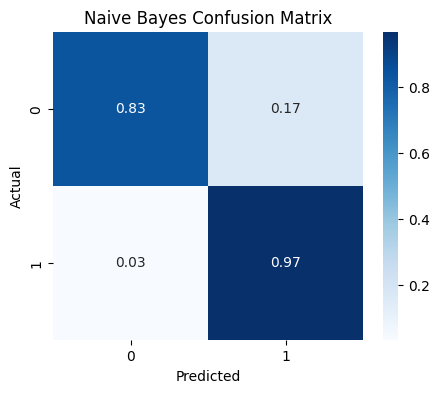

In [ ]:
conf_mat = confusion_matrix(test_y, y_pred_nb)

row_sums = conf_mat.sum(axis=1)

norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

## Logistic Regression

In [31]:
# Khởi tạo mô hình Logistic Regression
lr_model = LogisticRegression(random_state=42)

# Huấn luyện mô hình với tập train
lr_model.fit(X_resampled, y_resampled)

# Dự đoán nhãn trên tập test
y_pred_lr = lr_model.predict(test_x_tfidf)

In [32]:
print(classification_report(test_y, y_pred_lr))

              precision    recall  f1-score   support

    negative       0.79      0.86      0.83        36
    positive       0.98      0.97      0.98       277

    accuracy                           0.96       313
   macro avg       0.89      0.92      0.90       313
weighted avg       0.96      0.96      0.96       313



In [33]:
# Lưu mô hình
dump(lr_model, 'model_logistic_regression.joblib')

['model_logistic_regression.joblib']

In [ ]:
accuracy = accuracy_score(test_y, y_pred_lr)
precision = precision_score(test_y, y_pred_lr,  average='weighted')
recall = recall_score(test_y, y_pred_lr,  average='weighted')
f1 = f1_score(test_y, y_pred_lr,  average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9584664536741214
Precision: 0.9602576360697674
Recall: 0.9584664536741214
F1 Score: 0.9591840568701692


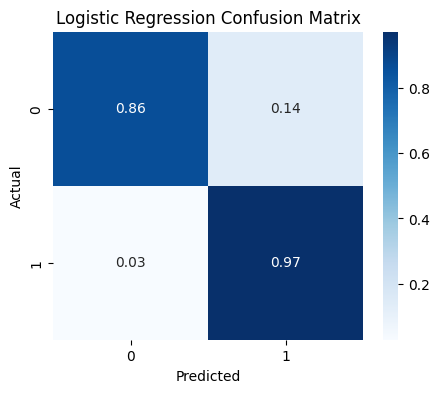

In [ ]:
conf_mat = confusion_matrix(test_y, y_pred_lr)

row_sums = conf_mat.sum(axis=1)

norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

## Random Forest

In [34]:
# Tạo mô hình Random Forest
model_rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Huấn luyện mô hình với dữ liệu huấn luyện Word2Vec
model_rf.fit(X_resampled, y_resampled)

# Dự đoán với dữ liệu kiểm tra
y_pred_rf= model_rf.predict(test_x_tfidf)

In [35]:
print(classification_report(test_y, y_pred_rf))

              precision    recall  f1-score   support

    negative       0.88      0.64      0.74        36
    positive       0.95      0.99      0.97       277

    accuracy                           0.95       313
   macro avg       0.92      0.81      0.86       313
weighted avg       0.95      0.95      0.95       313



In [38]:
# Lưu mô hình
dump(model_rf, 'model_random_forest.joblib')

['model_random_forest.joblib']

In [ ]:
accuracy = accuracy_score(test_y, y_pred_rf)
precision = precision_score(test_y, y_pred_rf, average='weighted')
recall = recall_score(test_y, y_pred_rf, average='weighted')
f1 = f1_score(test_y, y_pred_rf, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9488817891373802
Precision: 0.9466425415930598
Recall: 0.9488817891373802
F1 Score: 0.9452125284057061


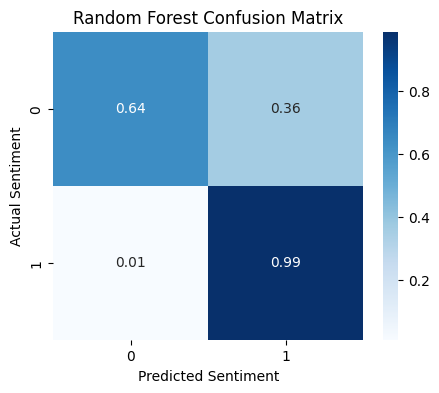

In [ ]:
conf_mat = confusion_matrix(test_y, y_pred_rf)

row_sums = conf_mat.sum(axis=1)

norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Random Forest Confusion Matrix')
plt.show()

## LSTM

In [39]:
# Kích thước của vector nhúng
embedding_dim = w2v_model.vector_size

# Xây dựng mô hình LSTM
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=100, return_sequences=True, input_shape=(1, embedding_dim)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(units=50, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(units=50, return_sequences=False))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=2, activation="softmax"))


# Biên dịch mô hình
model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model_LSTM.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 50)               │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,902 (511.34 KB)

 Trainable params: 130,902 (511.34 KB)

 Non-trainable params: 0 (0.00 B)

None


In [40]:
def get_vector(word_list, model):
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        if word in model.wv:
            vec += model.wv.get_vector(word).reshape((1, model.vector_size))
            count += 1.
    if count != 0:
        vec /= count
    return vec

# Tạo dữ liệu cho huấn luyện
X_train = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_train])
X_valid = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_valid])

In [41]:
from sklearn.preprocessing import LabelEncoderlabel_encoder = LabelEncoder()

train_y_encoded = label_encoder.fit_transform(train_y)
valid_y_encoded = label_encoder.transform(valid_y)

train_y_categorical = to_categorical(train_y_encoded)
valid_y_categorical = to_categorical(valid_y_encoded)

X_train = X_train.reshape(-1, 1, embedding_dim)
X_valid = X_valid.reshape(-1, 1, embedding_dim)

In [42]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_y_encoded),
    y=train_y_encoded
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weight_dict)

{0: 4.442073170731708, 1: 0.5634184068058778}


In [43]:
# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_LSTM.fit(X_train, train_y_categorical, epochs=50, batch_size=32, validation_data=(X_valid, valid_y_categorical), class_weight=class_weight_dict, callbacks=[early_stopping])

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.1817 - loss: 0.7085 - val_accuracy: 0.8814 - val_loss: 0.6801
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8809 - loss: 0.6657 - val_accuracy: 0.7468 - val_loss: 0.5617
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6704 - loss: 0.6071 - val_accuracy: 0.5353 - val_loss: 0.6610
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6209 - loss: 0.5463 - val_accuracy: 0.5801 - val_loss: 0.6151
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6579 - loss: 0.5718 - val_accuracy: 0.5609 - val_loss: 0.6277


In [48]:
# Lưu mô hình
model_LSTM.save('model_lstm.h5')

In [ ]:
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in all_tokens_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_pred = ['positive' if label == 1 else 'negative' for label in y_pred]

y_true = test_y

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8690095846645367
Recall: 0.8293221018852788
Precision: 0.7136351808482956
F1 Score: 0.7499074308654727


In [ ]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

    negative       0.46      0.78      0.58        36
    positive       0.97      0.88      0.92       277

    accuracy                           0.87       313
   macro avg       0.71      0.83      0.75       313
weighted avg       0.91      0.87      0.88       313



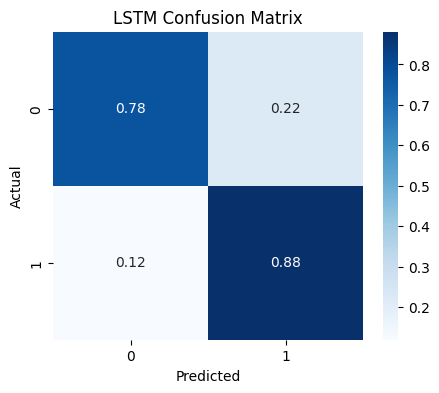

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)

row_sums = conf_mat.sum(axis=1)

norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

plt.figure(figsize=(5,4))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()